In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('all-star-dataset.csv')
df = df.dropna(subset=['player'])

EDA

In [3]:
print("Head of the dataset:")
print(df.head(), "\n")

print("Dataset info:")
print(df.info(), "\n")

print("Summary statistics:")
print(df.describe(), "\n")

df.fillna(df.select_dtypes(include=[np.number]).median(), inplace=True)

Head of the dataset:
   season             player  player_id   g    gs      mp   fg  fga   x3p  \
0    2020           Naz Reid     4771.0  30  11.0   495.0  100  243  32.0   
1    1996      Danny Manning     2417.0  33   4.0   816.0  178  388   3.0   
2    1991  Dwayne Schintzius     2582.0  42   7.0   398.0   68  155   0.0   
3    2017      Zach Randolph     3362.0  73   5.0  1786.0  433  964  21.0   
4    2012    DeMarre Carroll     3873.0  24   9.0   348.0   43  105   7.0   

   x3pa  ...  fta    orb    drb  ast   stl   blk   tov   pf   pts  all_star  
0  97.0  ...   53   34.0   90.0   35  19.0  22.0  22.0   83   269     False  
1  14.0  ...  109   30.0  113.0   65  38.0  24.0  77.0  121   441     False  
2   2.0  ...   40   28.0   93.0   17   2.0  29.0  34.0   64   158     False  
3  94.0  ...  193  182.0  416.0  122  38.0  10.0  99.0  136  1028     False  
4  19.0  ...   16   28.0   25.0   18  12.0   1.0  11.0   37   107     False  

[5 rows x 23 columns] 

Dataset info:
<class 'p

Explore Features

In [4]:
# Points per minute (handle division by zero)
df['ppm'] = np.where(df['mp'] > 0, df['pts'] / df['mp'], 0)

# Shooting percentages (avoid division by zero)
df['fg_pct']   = np.where(df['fga'] > 0, df['fg'] / df['fga'], 0)
df['x3p_pct']  = np.where(df['x3pa'] > 0, df['x3p'] / df['x3pa'], 0)
df['x2p_pct']  = np.where(df['x2pa'] > 0, df['x2p'] / df['x2pa'], 0)
df['ft_pct']   = np.where(df['fta'] > 0, df['ft'] / df['fta'], 0)

# Assist-to-turnover ratio (if turnovers is 0, assign 0)
df['ast_tov'] = np.where(df['tov'] > 0, df['ast'] / df['tov'], 0)

# Total rebounds as a new feature
df['reb'] = df['orb'] + df['drb']

# Minutes per game
df['mpg'] = np.where(df['g'] > 0, df['mp'] / df['g'], 0)

Feature Selection

In [5]:
features_all_star = df.drop(columns=['player', 'season', 'all_star'])
X_all_star = features_all_star.select_dtypes(include=[np.number])
y_all_star = df['all_star']

# Use a Random Forest classifier to rank feature importance
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_all_star, y_all_star)
importances = clf.feature_importances_
feat_importances = pd.Series(importances, index=X_all_star.columns)
feat_importances = feat_importances.sort_values(ascending=False)
print("Feature importances for predicting All-Star status:")
print(feat_importances, "\n")

Feature importances for predicting All-Star status:
pts          0.131429
mpg          0.119639
ft           0.086624
fta          0.077627
fg           0.076954
fga          0.068853
ppm          0.051297
x2pa         0.040120
tov          0.035873
x2p          0.030450
reb          0.027624
drb          0.024967
ast          0.019184
gs           0.018992
mp           0.017147
pf           0.016527
stl          0.015573
x2p_pct      0.015386
ast_tov      0.015193
blk          0.014924
g            0.014649
fg_pct       0.014116
player_id    0.013571
ft_pct       0.012329
orb          0.011984
x3p_pct      0.010938
x3pa         0.009029
x3p          0.009001
dtype: float64 



Model Selection & Training

In [6]:
# Use selected features to predict 'mpg' (minutes played per game)
features = df[['pts', 'ft', 'fta', 'fg', 'fga', 'ppm', 'x2pa', 'tov', 'x2p', 'reb', 'drb', 'ast']]
target = df['mpg']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----- Linear Regression -----
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# ----- Decision Tree Regressor -----
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_scaled, y_train)
y_pred_dt = dt.predict(X_test_scaled)

# ----- Random Forest Regressor -----
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

Model Evaluation

In [7]:
def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    print(f"{name} - RMSE: {rmse:.2f}, R^2: {r2:.2f}")

print("Model Evaluation on Test Data:")
evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Decision Tree", y_test, y_pred_dt)
evaluate_model("Random Forest", y_test, y_pred_rf)
print("\n")

Model Evaluation on Test Data:
Linear Regression - RMSE: 4.60, R^2: 0.82
Decision Tree - RMSE: 5.51, R^2: 0.74
Random Forest - RMSE: 3.87, R^2: 0.87




Analysis

In [8]:
# Use the best performing model (e.g., Random Forest) to predict ideal minutes for all players.
df['predicted_mpg'] = rf.predict(scaler.transform(features))
df['difference'] = df['predicted_mpg'] - df['mpg']

# Identify overutilized players (actual minutes significantly higher than predicted)
overutilized = df.sort_values(by='difference').head(10)
# Identify underutilized players (actual minutes significantly lower than predicted)
underutilized = df.sort_values(by='difference', ascending=False).head(10)

print("Top 10 Overutilized Players (predicted ideal < actual):")
print(overutilized[['player', 'mpg', 'predicted_mpg', 'difference']], "\n")
print("Top 10 Underutilized Players (predicted ideal > actual):")
print(underutilized[['player', 'mpg', 'predicted_mpg', 'difference']], "\n")

Top 10 Overutilized Players (predicted ideal < actual):
                  player        mpg  predicted_mpg  difference
1595  Zydrunas Ilgauskas  34.200000       8.632406  -25.567594
1971         Rusty LaRue  32.250000       9.943068  -22.306932
3505      Jamal Mashburn  35.625000      16.214997  -19.410003
625           Dino Radja  34.960000      15.740964  -19.219036
724            Glen Rice  30.300000      13.642013  -16.657987
1010    Oliver Lafayette  22.000000       6.589829  -15.410171
1187      Ramon Sessions  26.470588      13.000664  -13.469924
2123      Victor Oladipo  21.625000       8.206454  -13.418546
3408      Tyson Chandler  32.111111      19.133949  -12.977162
4278        Chris Mullin  41.347826      28.849882  -12.497944 

Top 10 Underutilized Players (predicted ideal > actual):
                 player        mpg  predicted_mpg  difference
12    Rodrigue Beaubois  12.500000      23.940501   11.440501
109       Moritz Wagner  17.687500      29.123862   11.436362
2499  

Visualizing Results

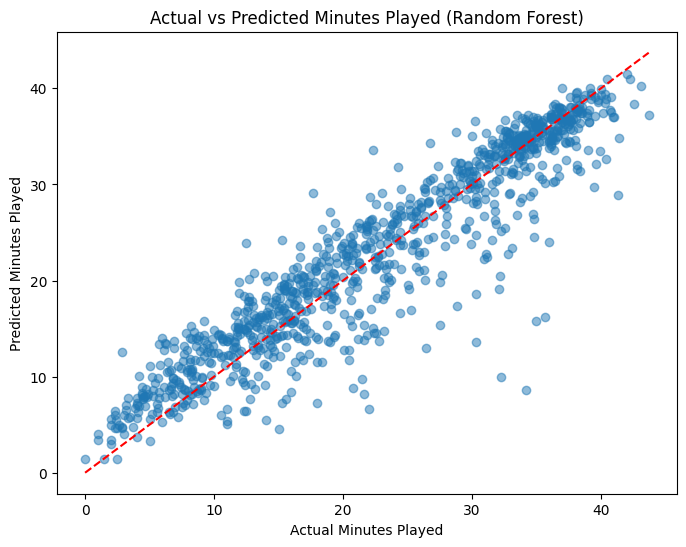

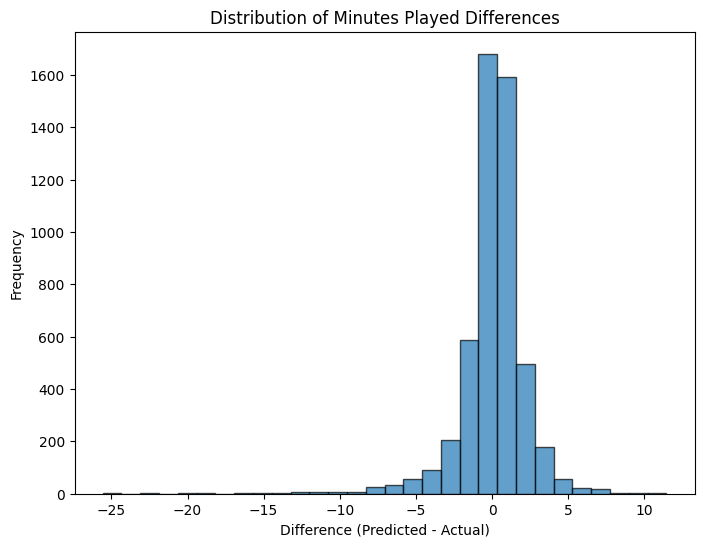

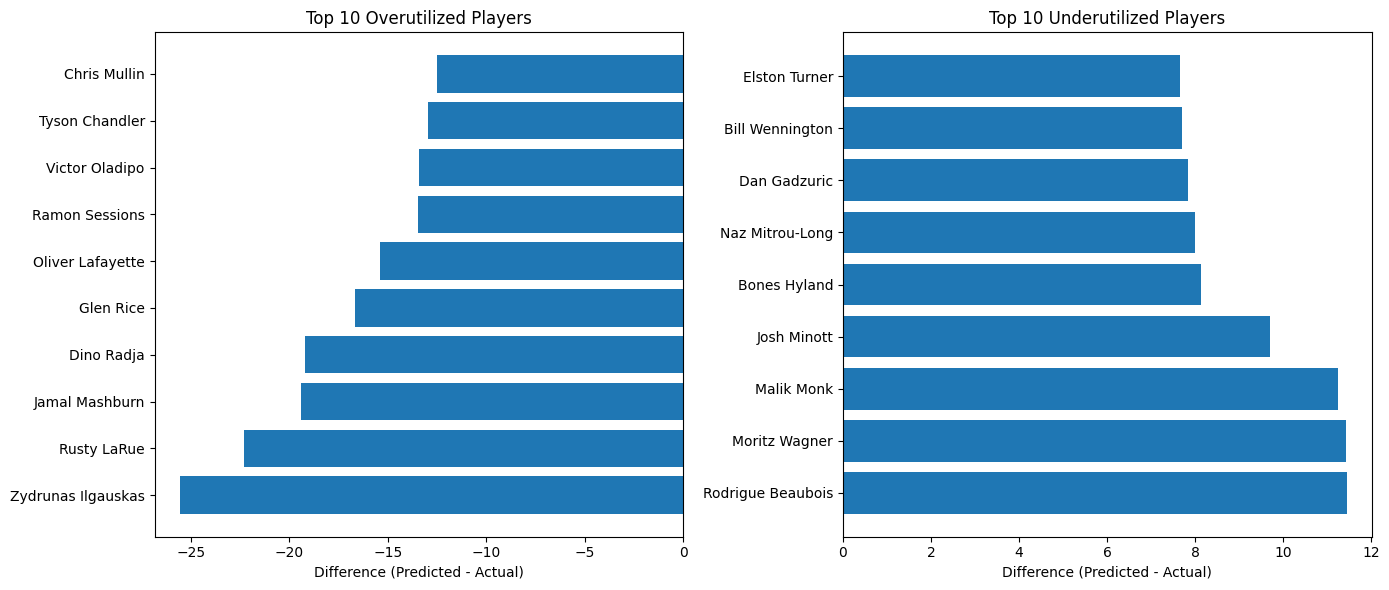

In [9]:
# Scatter plot: Actual vs Predicted Minutes (Random Forest)
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.xlabel("Actual Minutes Played")
plt.ylabel("Predicted Minutes Played")
plt.title("Actual vs Predicted Minutes Played (Random Forest)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# Histogram of differences
plt.figure(figsize=(8,6))
plt.hist(df['difference'], bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Difference (Predicted - Actual)")
plt.ylabel("Frequency")
plt.title("Distribution of Minutes Played Differences")
plt.show()

# Bar charts for top overutilized and underutilized players
fig, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].barh(overutilized['player'], overutilized['difference'])
ax[0].set_title("Top 10 Overutilized Players")
ax[0].set_xlabel("Difference (Predicted - Actual)")
ax[1].barh(underutilized['player'], underutilized['difference'])
ax[1].set_title("Top 10 Underutilized Players")
ax[1].set_xlabel("Difference (Predicted - Actual)")
plt.tight_layout()
plt.show()
